<a href="https://colab.research.google.com/github/qkrwogus1213/projects/blob/main/AI_18_Section2_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install category_encoders
!pip install scikit-learn==1.1.3
!pip3 install hyperopt
!pip3 install category_encoders

# 1. 목표
영화 데이터를 활용하여 영화 관객수를 예측해보자


# 1. 데이터 선정

- DACON에서 진행하는 영화 관객수 예측 대회의 데이터를 사용
- 데이터 상세 설명 : 
2010년대 한국에서 개봉한 한국영화 600개에 대한 감독, 이름, 상영등급, 관객수 등의 정보가 담긴 데이터



# 2. 데이터 설명
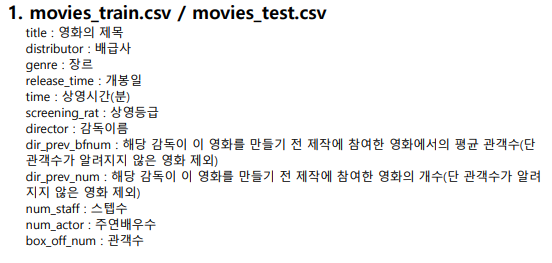

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
train = pd.read_csv("movies_train.csv")
test = pd.read_csv("movies_test.csv")
train.head()

In [ ]:
train.info()

In [ ]:
print("중복값 : ", train.duplicated().sum(),'\n')
print("장르 : ", train.genre.unique(), '\n')
print("--결측치-- \n",train.isnull().sum())

# 데이터 결측치 대체


In [ ]:
bfnum_null_train = train[train.dir_prev_bfnum.isna()]

tmp = 0
count = 0
for i in bfnum_null_train.index:
  duplication_director = train[train['director'] == bfnum_null_train.director.loc[i]]
  if len(duplication_director) > 1 :
      duplication_director = duplication_director.sort_values(by = 'release_time')
      for j in duplication_director.index:
        duplication_director.dir_prev_bfnum.loc[j] = tmp
        duplication_director.dir_prev_num.loc[j] = count
        count += 1
        tmp = round((tmp + duplication_director.box_off_num.loc[j]) / count)
        train.loc[j] = duplication_director.loc[j]
      tmp = 0
      count = 0
  elif len(duplication_director) == 1 :
    dp_index = duplication_director.index
    duplication_director.dir_prev_bfnum.loc[dp_index] = 0
    train.dir_prev_bfnum.loc[dp_index] = duplication_director.dir_prev_bfnum.loc[dp_index]
      
print("--결측치-- \n",train.isnull().sum())     

In [ ]:
train['release_time'] = pd.to_datetime(train['release_time'])
train['release_month'] = train['release_time'].dt.strftime('%m')
train['release_month'] = pd.to_numeric(train['release_month'])
train = train.drop('release_time', axis = 1)

test['release_time'] = pd.to_datetime(test['release_time'])
test['release_month'] = test['release_time'].dt.strftime('%m')
test['release_month'] = pd.to_numeric(test['release_month'])
test.drop('release_time', axis = 1)

In [ ]:
num_features = train.dtypes[train.dtypes!='object'].index
train[num_features].corr()['box_off_num'].sort_values(ascending=False).head(10)

In [ ]:
sns.heatmap(train.corr(), annot=True, fmt = '.2f')

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18,10))
sns.scatterplot(x = 'time', y = 'box_off_num', data = train, ax = ax[0,0])
sns.scatterplot(x = 'num_staff', y = 'box_off_num',  data = train, ax = ax[0,1])
sns.scatterplot(x = 'dir_prev_bfnum', y = 'box_off_num',  data = train, ax = ax[1,0])
sns.scatterplot(x = 'dir_prev_num', y = 'box_off_num',  data = train, ax = ax[1,1])

In [ ]:


target = 'box_off_num'
X_train = train.drop(['box_off_num','title','director','distributor'], axis = 1)
y_train = train[target]

def eval_models(y_pred, y_real = y_train) :
    mse = mean_squared_error(y_real, y_pred)
    rmse = np.sqrt(mse)
    # mae = mean_absolute_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)
    return rmse, r2

enc = OrdinalEncoder()
X_train_encoded = enc.fit_transform(X_train)


num_features = X_train.dtypes[train.dtypes!='object'].index
X_train_num = X_train[num_features]
multiple_ols = LinearRegression()
multiple_ols.fit(X_train_num, y_train)

multiple_rmse, multiple_r2 = eval_models(multiple_ols.predict(X_train_num))

print("rmse : ", multiple_rmse,'\n')
print("r2 : ", multiple_r2,'\n')

X_train_encoded


for i in range(len(multiple_ols.coef_)):
  print(X_train_num.columns[i], " : ", round(multiple_ols.coef_[i],2))
print(multiple_ols.intercept_)

In [ ]:
kf = KFold(n_splits=3)


rf = RandomForestRegressor(random_state = 42, max_depth = 3)
pred_result = []
eval_result = []
r2_result = []
cv_result_train = []
cv_result_val = []

for train_idx, test_idx in kf.split(X_train_encoded) :
    X_train_cv, X_val_cv = X_train_encoded .iloc[train_idx], X_train_encoded .iloc[test_idx]
    y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[test_idx]
    rf.fit(X_train_cv, y_train_cv)
    y_real = rf.predict(X_val_cv)
    mse = mean_squared_error(y_real, y_val_cv)
    rmse = np.sqrt(mse)
    eval_result.append(rmse)
    r2 = r2_score(y_val_cv, y_real)
    r2_result.append(r2)
    cv_result_train.append(rf.score(X_train_cv,y_train_cv))
    cv_result_val.append(rf.score(X_val_cv, y_val_cv))

rf1_result = np.mean(eval_result)

print("rmse : ", rf1_result)
print("r2 : ", np.mean(r2_result))
print("훈련 결정계수: ", sum(cv_result_train)/len(cv_result_train))
print("검증 결정계수: ", sum(cv_result_val)/len(cv_result_val))


In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [20,30,50,100, 150],
          'max_features': [2,3,4,5,6,7,8,9,10],
          'max_depth' : [2,3,4,5,6,7,8],
          }


grid_search = GridSearchCV(rf, param_grid=params, scoring="neg_mean_squared_error", cv=3, verbose=3)
grid_search.fit(X_train_encoded , y_train)

In [ ]:
grid_search.best_estimator_


In [ ]:
grid_result = grid_search.cv_results_
for mean_score, params in zip(grid_result["mean_test_score"], grid_result["params"]):
  print(np.sqrt(-mean_score), params)

In [ ]:
from sklearn.metrics import r2_score
kf = KFold(n_splits=3)


rf = RandomForestRegressor(max_depth=4, max_features=3, n_estimators=20,
                      random_state=42)
pred_result = []
eval_result = []
r2_result = []
cv_result_train = []
cv_result_val = []

for train_idx, test_idx in kf.split(X_train_encoded) :
    X_train_cv, X_val_cv = X_train_encoded .iloc[train_idx], X_train_encoded .iloc[test_idx]
    y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[test_idx]
    rf.fit(X_train_cv, y_train_cv)
    y_real = rf.predict(X_val_cv)
    mse = mean_squared_error(y_real, y_val_cv)
    rmse = np.sqrt(mse)
    eval_result.append(rmse)
    r2 = r2_score(y_val_cv,y_real)
    r2_result.append(r2)
    cv_result_train.append(rf.score(X_train_cv,y_train_cv))
    cv_result_val.append(rf.score(X_val_cv, y_val_cv))

rf2_result = np.mean(eval_result)

print("rmse : ", rf2_result)
print("r2 : ", np.mean(r2))
print("훈련 결정계수: ", sum(cv_result_train)/len(cv_result_train))
print("검증 결정계수: ", sum(cv_result_val)/len(cv_result_val))


In [ ]:
df = pd.DataFrame(
    {
       'name' : ['multiple_rmse', 'randomforest','grid_randomforest'],
       'rmse' : [round(multiple_rmse), round(rf1_result),round(rf2_result)]
    }
)
df